# Experiment on Features(1), CatBoost Model
Now the model has the best performance among tree models, but can we boost it further? To do that, I set experiments to do some feature modification. This is the 1st experiment.  

Visualize each feature to see their impact, and found that only 2-3 features have much say, the others don't explain.
- Next step: is this problem exists only in this model, or also on other models?

In [72]:
import numpy as np
from catboost import Pool, CatBoostRegressor
import json
import pandas as pd
from tqdm import trange
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
folds = 10
num_rounds = 50
esr = 3
depth = 6

In [5]:
from_file = CatBoostRegressor()
cat_model_1 = from_file.load_model("../para/limited_data/catboost_1.cbm")

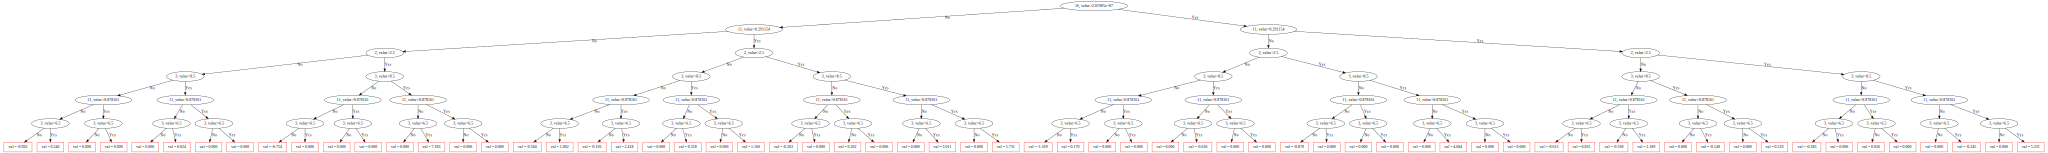

In [7]:
cat_model_1.plot_tree(tree_idx=0)

In [9]:
cat_model_1.get_feature_importance()

array([ 0.        ,  0.        ,  4.8673579 , 66.50141394,  0.        ,
        0.        ,  0.        ,  0.        ,  6.27057007,  0.        ,
        1.9697093 , 13.35675833,  0.        ,  0.        ,  4.09260891,
        0.        ,  2.94158154])

In [ ]:
for i in trange(1, folds + 1):
    print('model:', i)
    
    from_file = CatBoostRegressor()
    cat_model = from_file.load_model("../para/limited_data/catboost_{i}.cbm".format(i))

In [13]:
train_set = pd.read_csv('../data/limited_subtrain/train_3.tsv', sep='\t')
train_set['cross_city'] = train_set['cross_city'].astype('int')
train_set['cross_state'] = train_set['cross_state'].astype('int')
valid_set = pd.read_csv('../data/limited_subtrain/valid_3.tsv', sep='\t')
valid_set['cross_city'] = valid_set['cross_city'].astype('int')
valid_set['cross_state'] = valid_set['cross_state'].astype('int')

x_train = train_set.drop(['record_number', 'target'],axis=1)
y_train = train_set.target
x_valid = valid_set.drop(['record_number', 'target'],axis=1)
y_valid = valid_set.target

In [14]:
train_pool = Pool(x_train, 
              y_train, 
              cat_features=[0, 4, 7, 8, 12, 13],
              feature_names=list(x_train.columns))
test_pool = Pool(x_valid,
             y_valid,
             cat_features=[0, 4, 7, 8, 12, 13],
             feature_names=list(x_valid.columns)) 

In [16]:
class EbayMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            cur_approx = round(approx[i])
            residual = int(target[i] - cur_approx)
            if residual < 0:
                error_sum += w * -0.6 * residual
            else:
                error_sum += w * 0.4 * residual

        return error_sum, weight_sum

In [17]:
model = CatBoostRegressor(iterations=num_rounds, 
                      depth=depth, 
                      learning_rate=1, 
                      loss_function='RMSE',
                      eval_metric=EbayMetric())

model.fit(train_pool, early_stopping_rounds=3, eval_set=test_pool, use_best_model=True)
#model.save_model('para/catboost_experiment.cbm')

/home/zhangr235_gmail_com/anaconda3/envs/py38/lib/python3.8/site-packages/catboost/core.py:1953: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)


0:	learn: 0.4449322	test: 0.4451562	best: 0.4451562 (0)	total: 30.6s	remaining: 24m 58s
1:	learn: 0.4344996	test: 0.4348185	best: 0.4348185 (1)	total: 1m	remaining: 24m 20s
2:	learn: 0.4347691	test: 0.4352913	best: 0.4348185 (1)	total: 1m 31s	remaining: 23m 52s
3:	learn: 0.4342403	test: 0.4344233	best: 0.4344233 (3)	total: 2m 1s	remaining: 23m 15s
4:	learn: 0.4306027	test: 0.4307845	best: 0.4307845 (4)	total: 2m 31s	remaining: 22m 43s
5:	learn: 0.4299883	test: 0.4304846	best: 0.4304846 (5)	total: 3m 1s	remaining: 22m 11s
6:	learn: 0.4276829	test: 0.4282129	best: 0.4282129 (6)	total: 3m 39s	remaining: 22m 27s
7:	learn: 0.4260570	test: 0.4267480	best: 0.4267480 (7)	total: 4m 10s	remaining: 21m 56s
8:	learn: 0.4249781	test: 0.4255520	best: 0.4255520 (8)	total: 4m 41s	remaining: 21m 22s
9:	learn: 0.4235946	test: 0.4241394	best: 0.4241394 (9)	total: 5m 11s	remaining: 20m 45s
10:	learn: 0.4231002	test: 0.4237708	best: 0.4237708 (10)	total: 5m 41s	remaining: 20m 9s
11:	learn: 0.4231724	test: 

CatBoostError: (No such file or directory) util/system/file.cpp:856: can't open "para/catboost_experiment.cbm" with mode WrOnly|CreateAlways|Seq (0x00000034)

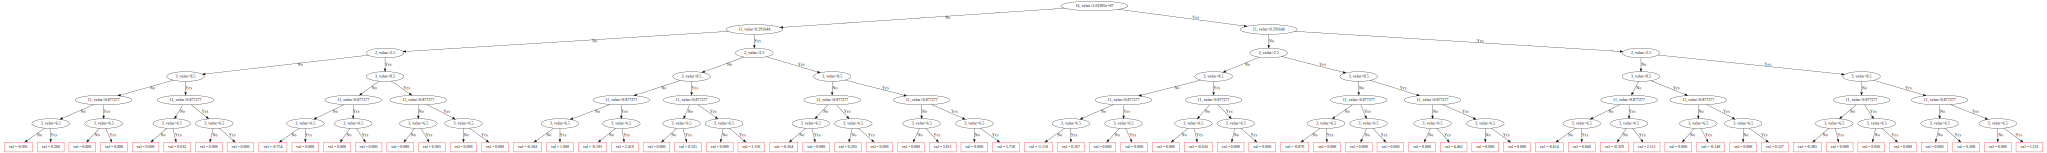

In [18]:
model.plot_tree(tree_idx=0)

In [ ]:
feature_score = model.get_feature_importance(data = train_pool, type = 'ShapValues')
# ShapValues: A vector with contributions of each feature to the prediction for every input object and 
# the expected value of the model prediction for the object (average prediction given no knowledge about the object).
shap_val = np.sum(feature_score, axis=0)
# drop the last col, the model prediction 
# shap_val_res = np.delete(shap_val, -1)

In [74]:
import pkg_resources
pkg_resources.require("Numpy==1.20.3")
import numpy
import shap

VersionConflict: (numpy 1.21.5 (/home/zhangr235_gmail_com/anaconda3/envs/py38/lib/python3.8/site-packages), Requirement.parse('Numpy==1.20.3'))

In [46]:
feature_importance = model.get_feature_importance(data = train_pool,
                                              type = 'FeatureImportance')
feature_importance

array([ 0.        ,  1.30460592,  3.82716153, 52.85184418,  1.25232986,
        0.44099868,  0.        ,  0.34245666,  5.51248813,  0.64823258,
        2.66565364, 13.44272755,  0.        ,  1.47317685,  5.13631338,
        0.        , 11.10201105])

In [47]:
# equal to feature_importance for non-ranking metrics 
pred_val_change = model.get_feature_importance(data = train_pool,
                                              type = 'PredictionValuesChange')
pred_val_change

array([ 0.        ,  1.30460592,  3.82716153, 52.85184418,  1.25232986,
        0.44099868,  0.        ,  0.34245666,  5.51248813,  0.64823258,
        2.66565364, 13.44272755,  0.        ,  1.47317685,  5.13631338,
        0.        , 11.10201105])

In [44]:
loss_change_score = model.get_feature_importance(data = train_pool,
                                              type = 'LossFunctionChange')
loss_change_score

array([0.        , 0.00120607, 0.06075114, 0.13191854, 0.00113903,
       0.00033143, 0.        , 0.00021735, 0.00352627, 0.00064906,
       0.00176421, 0.02898922, 0.        , 0.00195986, 0.00515637,
       0.        , 0.01338798])

In [76]:
features = x_train.columns
d = {'feature_name':x_train.columns, 'SHAP value':shap_val_res, 'feature_importance':feature_importance,'loss_change':loss_change_score}
feature_score = pd.DataFrame(data=d)
feature_score

,feature_name,SHAP value,feature_importance,loss_change
0,shipment_method_id,0.000000,0.000000,0.000000
1,shipping_fee,1342.767622,1.304606,0.001206
2,carrier_min_estimate,-379866.473504,3.827162,0.060751
3,carrier_max_estimate,381775.045528,52.851844,0.131919
4,category_id,11622.120077,1.252330,0.001139
5,item_price,-2955.254332,0.440999,0.000331
6,quantity,0.000000,0.000000,0.000000
7,bt,-3483.291564,0.342457,0.000217
8,package_size,-6027.156105,5.512488,0.003526
9,weight,-16481.649835,0.648233,0.000649


<AxesSubplot:>

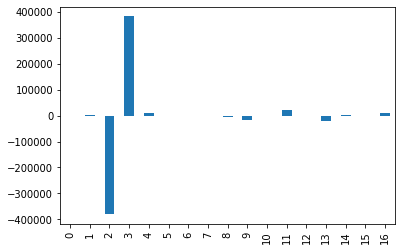

In [79]:
feature_score['SHAP value'].plot.bar()

<AxesSubplot:>

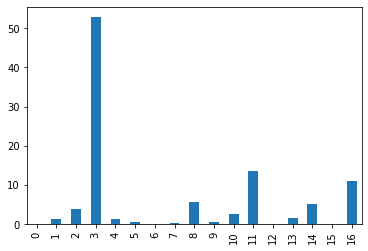

In [82]:
feature_score['feature_importance'].plot.bar()

<AxesSubplot:>

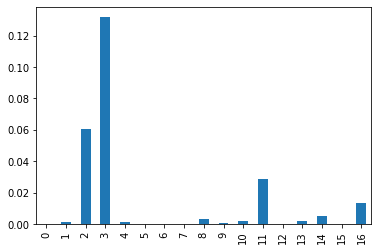

In [81]:
feature_score['loss_change'].plot.bar()

Try another model:

In [ ]:
# equal to feature_importance for non-ranking metrics 
pred_val_change = model.get_feature_importance(data = train_pool,
                                              type = 'PredictionValuesChange')
pred_val_change